In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import minimize

### Theory: SHG in Quasi-Phase-Matched Nonlinear Crystals

This section models Second Harmonic Generation (SHG) in a quasi-phase-matched (QPM) nonlinear crystal. The goal is to calculate the SHG intensity as a function of temperature, crystal length, and phase-matching conditions.

#### 0. SHG Setup

![Alt text](setup.PNG)

#### 1. Material Properties and Refractive Index

The refractive index of the nonlinear crystal depends both on the wavelength and temperature. For our simulations:

- **Sellmeier equation**: Provides the wavelength-dependent refractive index $n(\lambda)$ of the nonlinear material at room temperature. 
$$
n^2(\lambda) = 2.12725 + \frac{1.18431}{1 - (0.0514852/\lambda^2)} + \frac{0.6603}{1 - (100.0057/\lambda^2)} - 9.68956\times 10^{-3} \lambda^2
$$


- **Temperature correction**: The refractive index varies with temperature $T$ due to thermo-optic effects:
$$
\Delta n(\lambda, T) = (a_{10} + \frac{a_{11}}{\lambda} + \frac{a_{12}}{\lambda^2} + \frac{a_{13}}{\lambda^3})(T-25) + (a_{20} + \frac{a_{21}}{\lambda} + \frac{a_{22}}{\lambda^2} + \frac{a_{23}}{\lambda^3})(T-25)^2
$$

The total refractive index at temperature $T$ is then:
$$
n(\lambda, T) = n(\lambda) + \Delta n(\lambda, T)
$$

This allows us to account for the shift in phase-matching conditions with temperature.

---

#### 2. Wavevectors and Phase Matching

The wavevector for a given wavelength in the crystal is:
$$
k(\lambda, T) = \frac{2\pi}{\lambda} n(\lambda, T)
$$

For SHG, the phase mismatch is defined as:
$$
\Delta k = k(2\omega) - 2 k(\omega)
$$
where $k(\omega)$ is the fundamental wavevector and $k(2\omega)$ is the second harmonic.

To achieve efficient SHG in periodically poled crystals, we introduce a quasi-phase-matching (QPM) grating with period $\Lambda(T)$, which compensates the phase mismatch by a spatial frequency $2\pi / \Lambda(T)$. 

The effective phase mismatch is then:
$$
\Delta k_\text{eff} = \Delta k - \frac{2\pi}{\Lambda(T)}
$$

![Alt text](PPKTP_SCHEME.webp)


---

#### 3. SHG Intensity

The intensity of the generated second harmonic is proportional to the square of the nonlinear polarization. For a Gaussian pump beam with waist $w_0$, crystal length $L$, and effective nonlinear coefficient $d_\text{eff}$, the SHG intensity is:

$$
I_{2\omega} = \frac{32 \, d_\text{eff}^2 \, \omega^2 \, I_\omega^2 \, L^2}{n_\omega^2 \, n_{2\omega} \, \epsilon_0 c^2} \, \mathrm{sinc}^2\left( \frac{\Delta k_\text{eff} L}{2} \right)
$$

where $I_\omega = P_\omega / (\pi w_0^2)$ is the fundamental intensity and $\mathrm{sinc}(x) = \sin(x)/x$.  

The sinc term accounts for the reduction in SHG efficiency when the phase mismatch $\Delta k_\text{eff}$ is nonzero, which happens if the crystal is detuned in wavelength or temperature.



In [ ]:
alpha = 6.7e-6   
beta = 11e-9     
Lambda0 = 24.692     # Nominal poling period in microns   
c = 299792458              
pi = np.pi
epsilon_0 = 8.854e-12    
lambda_fund = 1.55012  # Fundamental wavelength in microns
m = 808 # Number of periods


a10, a11, a12, a13 = 9.9587e-6, 9.9228e-6, -8.9603e-6, 4.1010e-6 # Temperature coefficients for Sellmeier equation
a20, a21, a22, a23 = -1.1882e-8, 10.459e-8, -9.8136e-8, 3.1481e-8 # Temperature coefficients for Sellmeier equation

# Sellmeier equation, Refractive index

def nz_lambda(lambda_m): 
    λ = lambda_m 
    term1 = 2.12725
    term2 = 1.18431 / (1 - (0.0514852 / λ**2))
    term3 = 0.6603 / (1 - (100.0057 / λ**2))
    term4 = -9.68956e-3 * λ**2
    return np.sqrt(term1 + term2 + term3 + term4)


# Temperature correction Δn(λ, T)

def Tnz(lambda_m, T_C):
    λ = lambda_m   
    T = T_C
    term1 = (a10 + a11/λ + a12/λ**2 + a13/λ**3) * (T - 25)
    term2 = (a20 + a21/λ + a22/λ**2 + a23/λ**3) * (T - 25)**2
    return term1 + term2

# Full refractive index nz(λ, T)

def nzT(lambda_m, T_C):
    return nz_lambda(lambda_m) + Tnz(lambda_m, T_C) 

# Wavevector k(λ, T)

def k(lambda_m, T_C):
    return (2 * pi * nzT(lambda_m, T_C)) / lambda_m

# Phase mismatch Δk(λ_s, λ_i, T_C)

def delta_k_1(lambda_s, lambda_i, T_C):
    lambda_3 = (lambda_s * lambda_i) / (lambda_s + lambda_i)
    return k(lambda_3, T_C) - k(lambda_s, T_C) - k(lambda_i, T_C)


# QPM contribution = 2π / Λ(T)
def qpm_contribution(T_C):
    return 2*pi / 24.7

# Correct Δk: base mismatch - QPM spatial frequency
def delta_k(lambda_s, lambda_i, T_C):
    return delta_k_1(lambda_s, lambda_i, T_C) #- (2*np.pi / 24.692) 

# SHG Intensity

def sinc(x):
    return np.sinc(x / np.pi)

def SHG_intensity(P_omega, w0, lambda_fund, L, T_C, deff):
    lambda_s = lambda_fund
    
    lambda_i = lambda_fund
    omega = 2 * pi * c / lambda_fund

    deltaK = delta_k(lambda_s, lambda_i, T_C)
    sinc_term = sinc(deltaK * L / 2)**2

    n_omega = nzT(lambda_fund, T_C)
    n_2omega = nzT(lambda_fund / 2, T_C)
    I_omega = P_omega / (pi * w0**2)

    I_SHG = (32 * deff**2 * omega**2 * I_omega**2 * L**2 * sinc_term) / \
            (n_omega**2 * n_2omega * epsilon_0 * c**2)

    return I_SHG, deltaK, sinc_term

### Poling Period vs Temperature

In quasi-phase-matched (QPM) nonlinear crystals, the poling period $\Lambda$ is designed to compensate for the phase mismatch $\Delta k$ between interacting waves. The poling period required for perfect QPM is:

$$
\Lambda(T) = \frac{2\pi}{\Delta k(T)}
$$

where $\Delta k(T)$ is the phase mismatch between the fundamental and second harmonic waves at temperature $T$. 

As the crystal temperature changes, both the refractive index and the thermal expansion of the crystal modify $\Delta k(T)$, which in turn changes the optimal poling period $\Lambda(T)$.  

The code here calculates and plots the poling period as a function of temperature in the range 20–80°C. This allows us to visualize how temperature tuning affects the quasi-phase-matching condition and helps in designing experiments for efficient SHG.


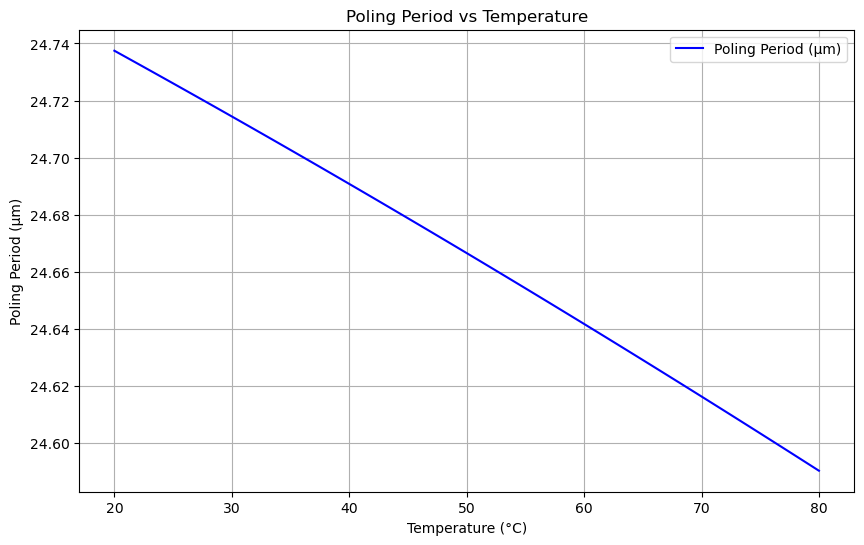

In [91]:
#poling period vs temperature
def plot_period_vs_temperature():
    T_C = np.linspace(20, 80, 100)  # Temperature range from 20 to 80 degrees Celsius
    periods = 2*pi/delta_k_1(1.55,1.55, T_C)  # Calculate poling periods for each temperature

    plt.figure(figsize=(10, 6))
    plt.plot(T_C, periods, label='Poling Period (µm)', color='blue')
    plt.title('Poling Period vs Temperature')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Poling Period (µm)')
    plt.grid()
    plt.legend()
    plt.show()

plot_period_vs_temperature()

### Poling Period vs Wavelength

The QPM poling period $\Lambda$ depends not only on temperature but also on the wavelength of the interacting waves. For SHG, the optimal poling period is given by:

$$
\Lambda(\lambda, T) = \frac{2\pi}{\Delta k(\lambda, T)}
$$


Since the refractive index varies with wavelength, a small change in the pump wavelength $\lambda$ shifts the phase mismatch, requiring a different poling period for efficient SHG.  

The code here calculates and plots the poling period as a function of wavelength around 1.55 µm at a fixed temperature of 40°C. This illustrates the sensitivity of QPM to wavelength and helps in designing poling periods for tunable SHG devices.


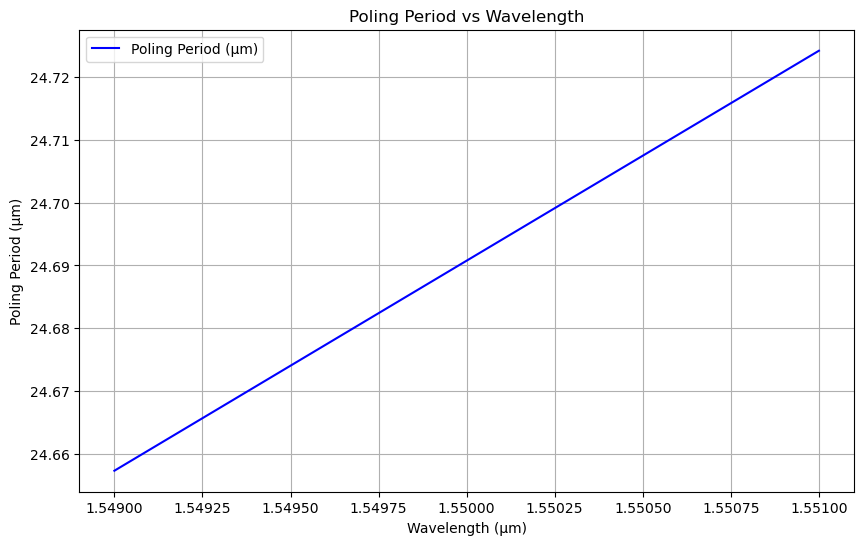

In [92]:
#poling period vs wavelength
def plot_period_vs_wavelength():
    wavelengths = np.linspace(1.549, 1.551, 100)  # Wavelength range from 1549 to 1551 nanometers
    periods = 2*pi/delta_k_1(wavelengths,wavelengths,40)  # Calculate poling periods for each wavelength

    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, periods, label='Poling Period (µm)', color='blue')
    plt.title('Poling Period vs Wavelength')
    plt.xlabel('Wavelength (µm)')
    plt.ylabel('Poling Period (µm)')
    plt.grid()
    plt.legend()
    plt.show()

plot_period_vs_wavelength()


#### QPM Coupling Intensity

The QPM interaction strength in a periodically poled crystal depends on the cumulative effect of all poling domains. For $m$ domains, the effective nonlinear coupling can be expressed as a sum over all domains:

$$
\text{QPM}_\text{coupling}(\phi) = \frac{d_\theta}{\pi} \sum_{k=0}^{m-1} \Big[ \cos\big(\phi + k (\Delta \theta - \Lambda) \frac{\pi}{d_\theta}\big) - \cos\big(\frac{\pi \Lambda}{d_\theta} + \phi + k (\Delta \theta - \Lambda) \frac{\pi}{d_\theta}\big) \Big]
$$

where:

- $d_\theta = 2\pi / \Delta k(T)$ is the phase accumulation per domain (distance over which the mismatch accumulates 2π phase),  
- $\Delta \theta$ is the period for perfect phase matching
- $\Lambda$ is the poling period,  
- $m$ is the number of domains,  
- $\phi$ is a phase offset.

The function `QPMintcoup(phi, dtheta, pol, m)` computes this sum numerically, giving the effective QPM coupling for a given crystal and temperature.  



In [93]:
def LT(base_period, T): # Linear temperature dependence of poling period
    return base_period * (1 + alpha * (T - 25) + beta * (T - 25)**2)

def QPMintcoup(phi, dtheta, pol, m):
    total = 0
    for k in range(m):
        arg1 = phi + (k * (dtheta - pol) * pi) / dtheta
        arg2 = (pi * pol / dtheta) + phi + (k * (dtheta - pol) * pi) / dtheta
        total += np.cos(arg1) - np.cos(arg2)
    return (dtheta / pi) * total

### Temperature Dependence of QPM Coupling

The efficiency of SHG in a quasi-phase-matched crystal depends strongly on temperature because both the refractive index and the poling period vary with temperature. This affects the effective nonlinear coupling over the entire crystal.

---

#### 1. QPM Coupling Ratio

For a crystal with $m$ domains, the **temperature-dependent QPM coupling** is calculated using:

$$
C(T) = \text{QPM}_\text{coupling}(\phi, d_\theta(T), \Lambda(T), m)
$$



To normalize the coupling, we compare it to a reference coupling at $T_\text{ref} = 26^\circ\text{C}$ with a slightly adjusted poling period $\Lambda_\text{ref} = \Lambda_0 + \Delta \Lambda$:

$$
F(T) = \left(\frac{C(T)}{C_\text{ref}}\right)^2
$$

This squared ratio represents the normalized QPM efficiency as a function of temperature.

---

#### 2. Interpretation

- The numerator in the code computes $C(T)$ for each temperature in the range 20–60°C.  
- The denominator is the reference coupling at $T_\text{ref}$ with a small poling adjustment to account for fabrication tolerances.  
- The final curve, `coupl`, shows how the normalized effective coupling varies with temperature, illustrating the sensitivity of SHG efficiency to thermal detuning.  



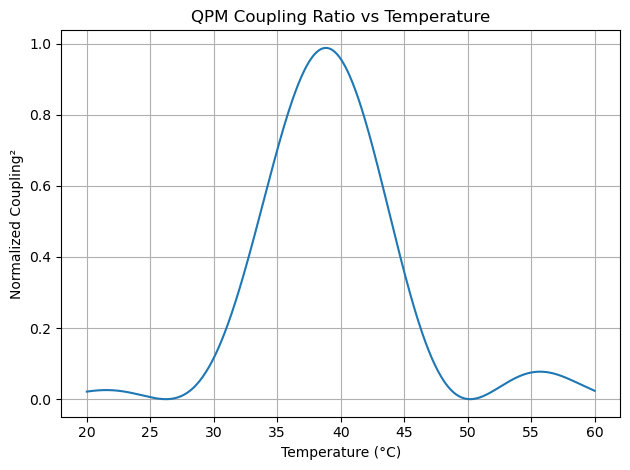

In [ ]:
# --- Temperature range ---
T_range = np.linspace(20, 60, 500)
phi = 1/2 * Lambda0
# --- Numerator: QPMintcoup at each T ---
numerator = []
for T in T_range:
    dtheta = 2*pi/delta_k(lambda_fund, lambda_fund, T)
    pol = LT(Lambda0, T)
    val = QPMintcoup(phi, dtheta, pol, m)
    numerator.append(val)

# --- Denominator: QPMintcoup at T = 26°C, shifted Λ ---
T_ref = 26
dtheta_ref = 2*pi/delta_k(lambda_fund, lambda_fund, T_ref)
pol_ref = LT(Lambda0 + 0.0347, T_ref)    # Adjusted poling period
denominator = QPMintcoup(0, dtheta_ref, pol_ref, m)

# --- Final function ---
coupl = (np.array(numerator) / denominator)**2

# --- Plot ---
plt.plot(T_range, coupl)
plt.xlabel("Temperature (°C)")
plt.ylabel("Normalized Coupling²")
plt.title("QPM Coupling Ratio vs Temperature")
plt.grid(True)
plt.tight_layout()
plt.show()


### QPM Coupling vs Temperature for Different Phase Offsets

The phase offset $\phi$ between the fundamental wave and the quasi-phase-matching (QPM) grating affects the effective nonlinear coupling in the crystal. Different values of $\phi$ can simulate deviations in the input phase or crystal alignment.

---

#### 1. Temperature-Dependent Coupling for Multiple $\phi$

As seen before, for each phase offset $\phi$, the normalized QPM coupling is calculated as:

$$
F(T, \phi) = \left( \frac{\text{QPM}_\text{coupling}(\phi, d_\theta(T), \Lambda(T), m)}{C_\text{ref}} \right)^2
$$


By varying $\phi$, we account for different phase-matching conditions along the crystal, which can occur due to fabrication imperfections or intentional phase tuning.




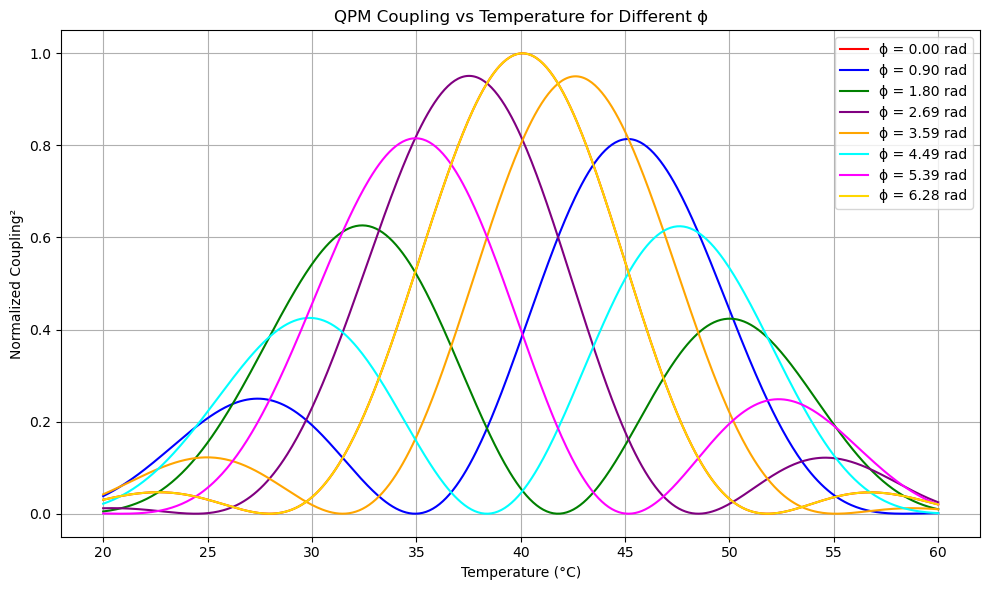

In [95]:
# --- Plot for multiple phi values ---
phi_list = np.linspace(0, 2*pi, 8)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'magenta', 'gold']

plt.figure(figsize=(10, 6))

for phi_val, color in zip(phi_list, colors):
    numerator = []
    for T in T_range:
        dtheta = 2 * np.pi / delta_k(lambda_fund, lambda_fund, T)
        pol = LT(Lambda0, T)
        val = QPMintcoup(phi_val, dtheta, pol, m)
        numerator.append(val)
    Figs11 = (np.array(numerator) / denominator)**2
    plt.plot(T_range, Figs11, label=f"ϕ = {phi_val:.2f} rad", color=color)

plt.xlabel("Temperature (°C)")
plt.ylabel("Normalized Coupling²")
plt.title("QPM Coupling vs Temperature for Different ϕ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Phase dependance (colors not adapted to the previous plot)

![image.png](phase_dependance.PNG)

### Resistance to temperature Interpolation

The temperature controller used measures the temperatues as the resistance passes through the "peltier". This plot here simply show the interpolation of those resistance values to temperature values from the provided constructor's data sheet.

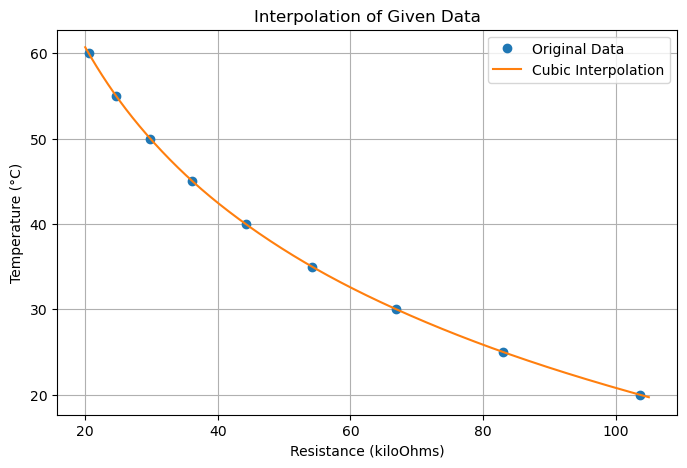

In [101]:
# Define your data
y_data = np.array([20, 25, 30, 35, 40, 45, 50, 55, 60])
x_data = np.array([103.6, 83, 66.91, 54.19, 44.18, 36.17, 29.8, 24.65, 20.51])

# Create the interpolation function
interp_func = interp1d(x_data, y_data, kind='cubic', fill_value="extrapolate")

# Example: Interpolate values
x_interp = np.linspace(20, 105, 500)
y_interp = interp_func(x_interp)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(x_data, y_data, 'o', label='Original Data')
plt.plot(x_interp, y_interp, '-', label='Cubic Interpolation')
plt.xlabel('Resistance (kiloOhms)')
plt.ylabel('Temperature (°C)')
plt.title('Interpolation of Given Data')
plt.legend()
plt.grid(True)
plt.show()

# Function to get interpolated y for a given x:
def interpolate_y(x_val):
    return interp_func(x_val)

### Experimental QPM Intensity Comparison: Good vs. Bad Crystals

This section illustrates how the quality of a quasi-phase-matched crystal affects the observed SHG intensity as a function of temperature.  

Accurate modeling of QPM and SHG in simulations should reproduce the trends observed experimentally, allowing prediction of optimal operating conditions and tolerances.


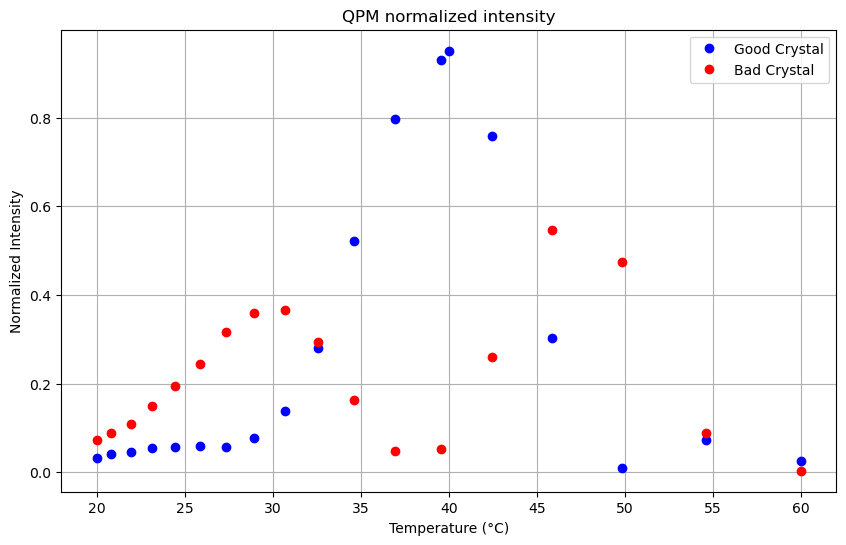

In [97]:
good_crystal_X = interpolate_y([103.6, 100, 95, 90, 85, 80, 75, 70, 65, 60, 55, 50, 45, 44.2, 40, 35, 30, 25, 20.5])
good_crystal_Y = (np.array([2.8, 3.1, 3.3, 3.6, 3.7, 3.8, 3.7, 4.4, 6.5, 11.5, 20, 29.6, 34.3, 35, 28.3, 12.3, 2, 4.2, 2.55]) -1.7) / 35

bad_crystal_X = interpolate_y([103.6, 100, 95, 90, 85, 80, 75, 70, 65, 60, 55, 50, 45, 40, 35, 30, 25, 20.5])
bad_crystal_Y = (np.array([3.9, 4.4, 5.1, 6.4, 7.85, 9.4, 11.7, 13.1, 13.3, 11, 6.8, 3.15, 3.3, 9.9, 19.1, 16.8, 4.4, 1.7]) - 1.6) / 32

# plotting the data points only (no lines)
plt.figure(figsize=(10, 6))
plt.plot(good_crystal_X, good_crystal_Y, 'o', label='Good Crystal', color='blue')
plt.plot(bad_crystal_X, bad_crystal_Y, 'o', label='Bad Crystal', color='red')
plt.xlabel('Temperature (°C)')
plt.ylabel('Normalized Intensity')
plt.title('QPM normalized intensity')
plt.grid(True)
plt.legend()

### Fitting QPM Model to Experimental Data


This fitting procedure demonstrates that the phase offset $\phi$ and poling uniformity** are critical parameters for achieving efficient SHG, and it provides a quantitative tool to evaluate crystal quality. A good crystal will be a crystal that can achieve a high QPM intensity value (having a phase in this case of 0), and a bad one won't achieve it, and will have pultiple relatively high picks.


Good Crystal → Best-fit phi: 0.000000 rad
Bad Crystal → Best-fit phi: 1.306706 rad


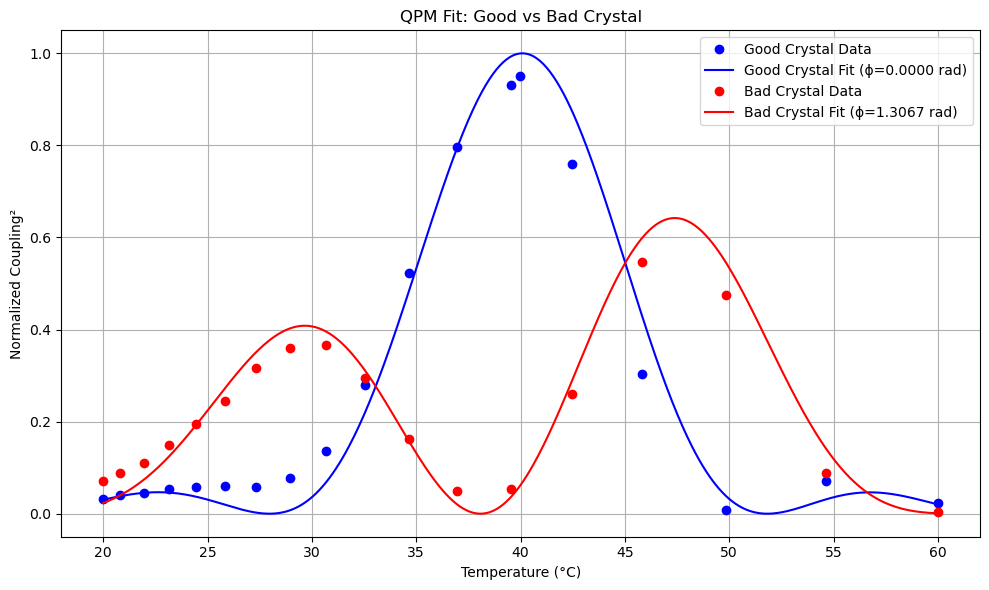

In [ ]:
from scipy.optimize import minimize

fig, ax = plt.subplots(figsize=(10, 6))

# Fitting function 
def fit_function(phi_array, T_array, pol, m):
    phi = phi_array[0]
    model = []
    for T in T_array:
        dtheta = 2 * np.pi / delta_k(lambda_fund, lambda_fund, T)
        val = QPMintcoup(phi, dtheta, LT(Lambda0, T), m)
        model.append((val / denominator) ** 2)
    return np.array(model)

# Error function for optimization
def error(phi_array, T_array, y_data, pol, m):
    y_model = fit_function(phi_array, T_array, pol, m)
    return np.sum((y_data - y_model) ** 2)

datasets = {
    "Good Crystal": (np.array(good_crystal_X), np.array(good_crystal_Y), "blue"),
    "Bad Crystal":  (np.array(bad_crystal_X),  np.array(bad_crystal_Y),  "red")
}

for label, (T_data, y_data, color) in datasets.items():
    # Optimization 
    phi0 = [0.0]
    bounds = [(0, 2*pi)] # Bounds for phi in radians

    result = minimize(
        error,
        phi0,
        args=(T_data, y_data, pol, m),
        method='L-BFGS-B', # Using L-BFGS-B for bounded optimization
        bounds=bounds,
        options={'maxiter': 10000, 'ftol': 1e-12} # high precision optimization
    )

    best_phi = result.x[0]
    print(f"{label} → Best-fit phi: {best_phi:.6f} rad")

    # Dense smooth fit curve 
    T_dense = np.linspace(T_data.min(), T_data.max(), 500)
    y_fit_dense = fit_function([best_phi], T_dense, pol, m)

    # Plot
    ax.plot(T_data, y_data, 'o', label=f'{label} Data', color=color)
    ax.plot(T_dense, y_fit_dense, '-', label=f'{label} Fit (ϕ={best_phi:.4f} rad)', color=color)

# Labels and formatting 
ax.set_title("QPM Fit: Good vs Bad Crystal")
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Normalized Coupling²")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


# Continuous-Wave OPO Gain and Squeezing

(Similar derivation to Oscar Cordero Boronat Masc Thesis. First OPO image taken from there.)

![Alt text](opo.PNG)

From the Langevin equations of the cavity field,

$
\frac{d\hat{a}'}{dt} = e^{i\omega_0 t}\!\left(i\omega_0 \hat{a} + \frac{d\hat{a}}{dt}\right) = g|\beta|e^{i\phi_g}\,\hat{a}^{\dagger\prime} - \gamma_s \hat{a}' + \sqrt{2\gamma_s^{M}}\,\hat{A}_{\mathrm{in}}^{M\,\prime} + \sqrt{2\gamma_s^{L}}\,\hat{A}^{L\,\prime} \,. $

$ 
\frac{d\hat{a}^{\dagger\prime}}{dt} = e^{-i\omega_0 t}\!\left(-i\omega_0 \hat{a}^\dagger + \frac{d\hat{a}^\dagger}{dt}\right) = g|\beta|e^{-i\phi_g}\,\hat{a}' - \gamma_s \hat{a}^{\dagger\prime} + \sqrt{2\gamma_s^{M}}\,\hat{A}_{\mathrm{in}}^{M,\dagger\prime} + \sqrt{2\gamma_s^{L}}\,\hat{A}^{L,\dagger\prime} \,. $


We derive two different analyses:

# Mean-Value (classical) Analysis

## 1. Introduction
In a continuous-wave (CW) optical parametric oscillator (OPO), parametric amplification is achieved when a strong pump field interacts with the nonlinear medium.  

Below threshold, the OPO behaves as a phase-sensitive amplifier:  

$
\alpha = \frac{\sqrt{2\gamma_s^M}\langle \hat{A}_{\text{in}}^M \rangle}{\gamma_s\big(1 - c e^{i(\phi + \phi_g)}\big)}
       = \frac{\alpha_0}{1 - c e^{i(\phi + \phi_g)}}.
$

- $\alpha$: intracavity mean-field amplitude of the signal mode.
- $\gamma_s$: cavity decay rate for the signal mode.
- $\gamma_s^M$: input coupling rate for the signal (mirror coupling).
- $\langle \hat{A}_{\text{in}}^M \rangle$: mean input field at the mirror port.
- $\phi$: signal phase.
- $\phi_g$: phase of the nonlinear interaction strength $g$.
- $\alpha_0 = \frac{\sqrt{2\gamma_s^M}\langle \hat{A}_{\text{in}}^M \rangle}{\gamma_s}$: normalization constant representing the signal amplitude in the absence of nonlinear interaction.
- For a signal phase aligned with the pump phase (`ϕg + ϕ = 0`), the field is amplified.  
- For a signal phase shifted by π (`ϕg + ϕ = π`), the field is de-amplified.  

This phase-sensitive behavior is the foundation for generating squeezed states of light.



---

## 2. Normalized Pump Parameter

We define the normalized pump parameter as:


$c = \frac{|g \, \beta|}{\gamma_s}$


where:
- $ g $ = nonlinear coupling strength  
- $ \beta $ = pump field amplitude  
- $\gamma_s$ = cavity decay rate for the signal  

The OPO threshold occurs at c = 1.

---

## 3. Parametric Gain

From mean-value analysis, the input-output gain of the OPO is:

- **Amplification case** $( \phi_g + \phi = 0 )$:

$
\left| \frac{\alpha}{\alpha_0} \right| = \frac{1}{1 - c}
$

- **De-amplification case** $( \phi_g + \phi = \pi )$:

$
\left| \frac{\alpha}{\alpha_0} \right| = \frac{1}{1 + c}
$

These relations show that the gain diverges as $c \to 1 $ (the OPO threshold).



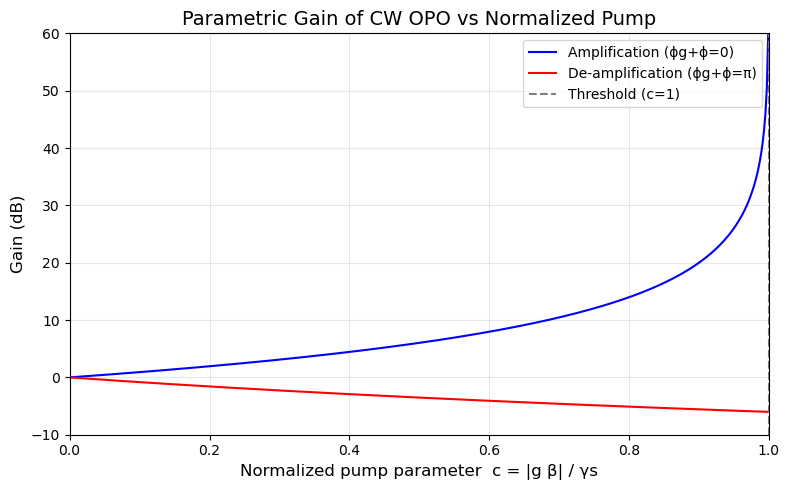

In [99]:
c_vals = np.linspace(0, 0.999, 500)   # normalized pump parameter: c = |g β| / γ_s

# Amplification (phi_g + phi = 0)
gain_amp = 1 / (1 - c_vals)          # |alpha/alpha0|
gain_amp_dB = 20 * np.log10(np.abs(gain_amp))  # in dB

# De-amplification (phi_g + phi = π)
gain_deamp = 1 / (1 + c_vals)        # |alpha/alpha0|
gain_deamp_dB = 20 * np.log10(np.abs(gain_deamp))


# Plot
plt.figure(figsize=(8, 5))
plt.plot(c_vals, gain_amp_dB, label="Amplification (ϕg+ϕ=0)", color='blue')
plt.plot(c_vals, gain_deamp_dB, label="De-amplification (ϕg+ϕ=π)", color='red')

plt.axvline(1, color='gray', linestyle='--', label="Threshold (c=1)")
plt.ylim(-10, 60)
plt.xlim(0, 1)
plt.xlabel("Normalized pump parameter  c = |g β| / γs", fontsize=12)
plt.ylabel("Gain (dB)", fontsize=12)
plt.title("Parametric Gain of CW OPO vs Normalized Pump", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Fluctuation (Quantum) Analysis

## 1. Introduction
In a CW OPO operated below threshold, vacuum fluctuations at analysis frequency $\Omega$ are de-amplified along one quadrature (squeezing) and amplified along the orthogonal quadrature (anti-squeezing). Linearizing the Heisenberg–Langevin equations and solving in the frequency domain yields two Lorentzian response terms that determine the measured homodyne noise spectrum.

---

## 2. Normalized Pump & Cavity Parameters
We use (same as for the classical case):
- Total amplitude decay rate of the signal mode $\gamma_s$ (bandwidth scale).
- External coupling (mirror) rate $\gamma_s^{M}$.
- **Escape efficiency** $\eta_{\mathrm{esc}} \equiv \gamma_s^{M}/\gamma_s \in (0,1]$.
- **Normalized pump** $c \in [0,1)$ (fraction of threshold power; $c \to 1^-$ approaches threshold).
- Analysis frequency $\Omega$ (same units as $\gamma_s$).
- Homodyne phase offset $\phi$ (only $2\theta-\phi$ matters for the measured quadrature).

Concrete choices (used by the code): $\gamma_s = 50~\text{MHz}$, $\eta_{\mathrm{esc}} = 0.98$, $\gamma_s^{M} = \eta_{\mathrm{esc}}\gamma_s$, $\phi = 0$.

---

## 3. Frequency-Domain Response 
Solving the linearized equations yields two Lorentzian weights:
$$
B(c,\Omega)=\frac{c\,\gamma_s^{M}\gamma_s}{\big(\gamma_s - c\gamma_s\big)^2+\Omega^2},
\qquad
C(c,\Omega)=\frac{c\,\gamma_s^{M}\gamma_s}{\big(\gamma_s + c\gamma_s\big)^2+\Omega^2}.
$$

Normalized form with $x \equiv \Omega/\gamma_s$ and $\eta_{\mathrm{esc}}=\gamma_s^{M}/\gamma_s$:
$$
B=\eta_{\mathrm{esc}}\;\frac{c}{(1-c)^2+x^2},
\qquad
C=\eta_{\mathrm{esc}}\;\frac{c}{(1+c)^2+x^2}.
$$

Interpretation:
- $B$ is associated with the amplified branch (anti-squeezed quadrature), peaking near $\gamma_s(1-c)$.
- $C$ is associated with the de-amplified branch (squeezed quadrature), peaking near $\gamma_s(1+c)$.

---

## 4. Quadrature Noise vs. Homodyne Angle 
For a homodyne angle $\theta$, the (single-sided) variance normalized to shot noise is
$$
V(\theta)=1+2\big(B+C\big)\cos\!\big(2\theta-\phi\big)+2\big(B-C\big).
$$
As $\theta$ varies, $V(\theta)$ traces an ellipse in quadrature space; its principal axes are the squeezed and anti-squeezed variances.

---

## 5. Optimal Squeezing and Anti-Squeezing 
Choosing $\cos(2\theta-\phi)=\pm 1$ gives the extrema:
$$
V_{\min}(c,\Omega)=1-\frac{4c\,\gamma_s^{M}\gamma_s}{\big(\gamma_s(1+c)\big)^2+\Omega^2},
\qquad
V_{\max}(c,\Omega)=1+\frac{4c\,\gamma_s^{M}\gamma_s}{\big(\gamma_s(1-c)\big)^2+\Omega^2}.
$$

Equivalently, with $x=\Omega/\gamma_s$ and $\eta_{\mathrm{esc}}=\gamma_s^{M}/\gamma_s$:
$$
V_{\min}=1-\eta_{\mathrm{esc}}\frac{4c}{(1+c)^2+x^2},
\qquad
V_{\max}=1+\eta_{\mathrm{esc}}\frac{4c}{(1-c)^2+x^2}.
$$




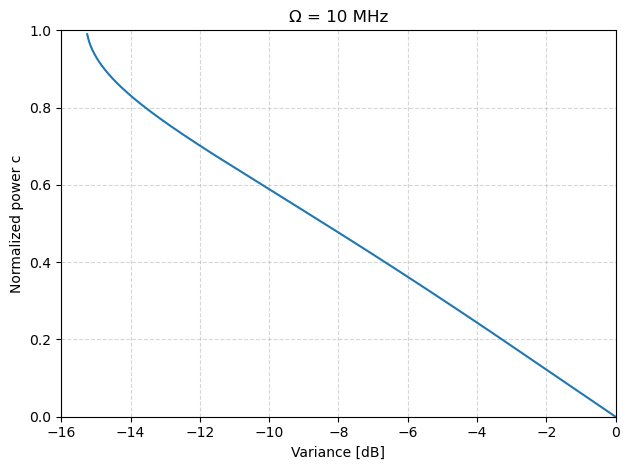

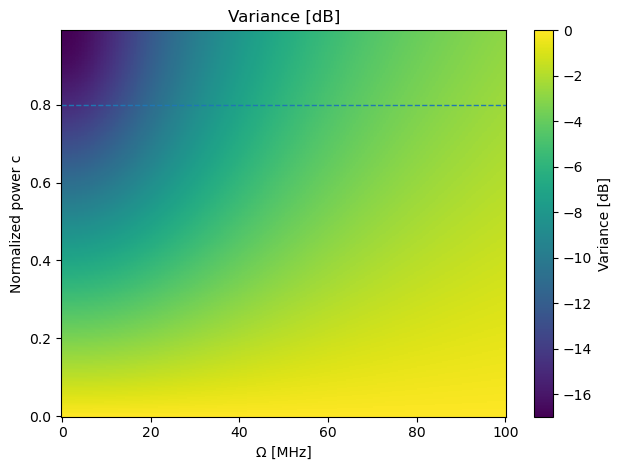

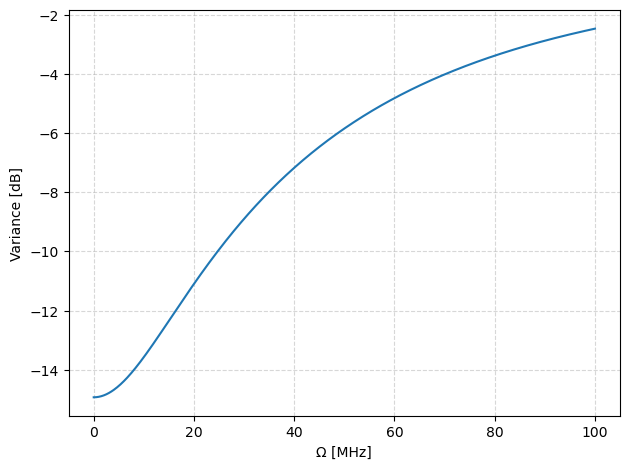

In [ ]:
gamma_s = 50.0          # MHz, cavity amplitude decay rate (linewidth scale)
eta_esc = 0.98          # escape efficiency = gamma_s^M / gamma_s
gamma_s_M = eta_esc * gamma_s
phi = 0.0               # homodyne phase reference


def B_val(c, Omega, gamma_s=gamma_s, gamma_s_M=gamma_s_M):
    """B = c γ_s^M γ_s / [ (γ_s - c γ_s)^2 + Ω^2 ]"""
    denom = (gamma_s * (1 - c))**2 + Omega**2
    return (c * gamma_s_M * gamma_s) / denom

def C_val(c, Omega, gamma_s=gamma_s, gamma_s_M=gamma_s_M):
    """C = c γ_s^M γ_s / [ (γ_s + c γ_s)^2 + Ω^2 ]"""
    denom = (gamma_s * (1 + c))**2 + Omega**2
    return (c * gamma_s_M * gamma_s) / denom

def variance_theta(c, Omega, theta, phi=phi):
    """V(θ) = 1 + 2(B + C)cos(2θ − φ) + 2(B − C)."""
    B = B_val(c, Omega)
    C = C_val(c, Omega)
    return 1 + 2*(B + C)*np.cos(2*theta - phi) + 2*(B - C)

def variance_min(c, Omega):
    """V_min = 1 − [4 c γ_s γ_s^M] / [(γ_s(1+c))^2 + Ω^2]"""
    denom = (gamma_s * (1.0 + c))**2 + Omega**2
    return 1.0 - (4.0 * c * gamma_s * gamma_s_M) / denom

def variance_max(c, Omega):
    """V_max = 1 + [4 c γ_s γ_s^M] / [(γ_s(1−c))^2 + Ω^2]"""
    denom = (gamma_s * (1.0 - c))**2 + Omega**2
    return 1.0 + (4.0 * c * gamma_s * gamma_s_M) / denom

def to_dB(var):
    """Linear variance → dB relative to shot noise (1)."""
    return 10*np.log10(var)


Omega_fixed = 10.0  # MHz
c_vals = np.linspace(0.0, 0.99, 600)
Vmin_dB_A = to_dB(variance_min(c_vals, Omega_fixed))

plt.figure()
plt.xlim(-16, 0)
plt.ylim(0, 1)
plt.plot(Vmin_dB_A, c_vals)
plt.xlabel("Variance [dB]")
plt.ylabel("Normalized power c")
plt.title("Ω = 10 MHz")
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.tight_layout()


Omega_grid = np.linspace(0.0, 100.0, 300)   
c_grid = np.linspace(0.0, 0.99, 300)        
Omesh, Cmesh = np.meshgrid(Omega_grid, c_grid)  
Vmin_grid_dB = to_dB(variance_min(Cmesh, Omesh))

plt.figure()
im = plt.pcolormesh(Omega_grid, c_grid, Vmin_grid_dB, shading="auto")
plt.xlabel("Ω [MHz]")
plt.ylabel("Normalized power c")
plt.title("Variance [dB]")
cb = plt.colorbar(im)
cb.set_label("Variance [dB]")
# guide line at c = 0.8 
plt.axhline(0.8, linestyle="--", linewidth=1)
plt.tight_layout()


c_fixed = 0.8
Omega_vals = np.linspace(0.0, 100.0, 600)
Vmin_Omega_dB = to_dB(variance_min(c_fixed, Omega_vals))

plt.figure()
plt.plot(Omega_vals, Vmin_Omega_dB)
plt.xlabel("Ω [MHz]")
plt.ylabel("Variance [dB]")
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.tight_layout()



#### Appendix

![Alt text](Donghwa_image.PNG)
